# **COMP 562 Group Project**
# **Loan Default Prediction Model**
###Kang Du, Jingtong E, Zhengnan Feng, Zihao Fang
###730359227, 730352968, 730365307, 730321222



# Set Up:
- Import the required libraris to run our Notebook
- Mount Google Drive
- Pull 'p' Proportion of the Lending Club Dataset 


In [ ]:
# Import libraries and mount drive
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/BUSI488/BUSI_488_Team_Assignments/488-Spring2022-TeamAssignment1_Section002-TeamDelta2/Data_Files/
!ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1ickds1-sp6iTvfGXu54II22uAER6ronQ/BUSI_488_Team_Assignments/488-Spring2022-TeamAssignment1_Section002-TeamDelta2/Data_Files
accepted_2007_to_2018Q4.csv  LCDataDictionary.xlsx  rejected_2007_to_2018Q4.csv


In [ ]:
#Pulling out p% of the Data Set. We lowered this during our exploratory phase.
p = 0.01
#Reading the data from 2007 to 2018 
data = pd.read_csv("accepted_2007_to_2018Q4.csv", header = 0, skiprows = lambda i: i > 0 and random.random() > p)

#56849 rows, 151 variables.
print("Dataframe shape is", data.shape)

Dataframe shape is (22586, 151)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19,118) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Take a cursory examination of our data 
- Use the head method to display the first 5 observations
- Use the describe method to obtain summary statistics on our variables
- Initialize 3 lists with each one containing the variables of a speciifc data type

In [ ]:
#Taking a look at the first five rows from our data 
data.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68436934,NaN,23975.0,23975.0,23975.0,60 months,19.89,633.73,E,E3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68565856,NaN,9000.0,9000.0,9000.0,36 months,9.17,286.92,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68416679,NaN,8725.0,8725.0,8725.0,36 months,11.99,289.76,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,68415164,NaN,26250.0,26250.0,26250.0,60 months,13.99,610.66,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68232437,NaN,11200.0,11200.0,11200.0,36 months,9.17,357.05,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Variable Selection
- We looked at the description of each variable in the codebook provided and narrowed down the data to just include features of concern

- Engineer the 'Fico' varaiable from the borrower's Fico score range 

In [ ]:
#Chosen features
cols = ['open_acc','funded_amnt', 'int_rate','term','verification_status','annual_inc',	'dti',	'installment',	'application_type',	'emp_length',	'grade','sub_grade',	'home_ownership',	'loan_status',	'fico_range_high','fico_range_low','issue_d']
#Print out the cols to ensure the list was properly initialized
cols

['open_acc',
 'funded_amnt',
 'int_rate',
 'term',
 'verification_status',
 'annual_inc',
 'dti',
 'installment',
 'application_type',
 'emp_length',
 'grade',
 'sub_grade',
 'home_ownership',
 'loan_status',
 'fico_range_high',
 'fico_range_low',
 'issue_d']

In [ ]:
#Makes a copy of the data with only the columns we are interested in
data = data[cols].copy()

In [ ]:
#Since each borrower's fico score is set within a range, we averaged the upper and lower bound
data['fico'] = (data['fico_range_high'] + data['fico_range_low'])/2
#Drop the upper and lower fico bound variables
data = data.drop(['fico_range_high', 'fico_range_low'], axis = 1)

In [ ]:
#Identifying the variables that are object data types
object_types = [column for column in data.columns if data[column].dtype == 'object']
#Identifying the variables that are float data types
float_types = [column for column in data.columns if data[column].dtype == 'float64']
#Print out the variables that are object data types
print("Object Type Variables: ",object_types)
#Print out the variables that are float data types
print("Float 64 Type Variables: ",float_types)

Object Type Variables:  ['term', 'verification_status', 'application_type', 'emp_length', 'grade', 'sub_grade', 'home_ownership', 'loan_status', 'issue_d']
Float 64 Type Variables:  ['open_acc', 'funded_amnt', 'int_rate', 'annual_inc', 'dti', 'installment', 'fico']


In [ ]:
#Keeping above variables but dropping issue_d
categorical_features = data.select_dtypes(include=['object', 'category']).drop(['issue_d'], axis=1).columns
#Printing out the categorical_features
print(categorical_features)

Index(['term', 'verification_status', 'application_type', 'emp_length',
       'grade', 'sub_grade', 'home_ownership', 'loan_status'],
      dtype='object')


In [ ]:
#A for loop which is converting the object type variables(categorical) into category data types
for col in categorical_features.tolist():
  #Reassign the variables in our dataset as a category
        data[col] = data[col].astype('category')

#Getting the data types gfor each variabel in the data frame to ensure changes are made
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22586 entries, 0 to 22585
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   open_acc             22586 non-null  float64 
 1   funded_amnt          22586 non-null  float64 
 2   int_rate             22586 non-null  float64 
 3   term                 22586 non-null  category
 4   verification_status  22586 non-null  category
 5   annual_inc           22586 non-null  float64 
 6   dti                  22578 non-null  float64 
 7   installment          22586 non-null  float64 
 8   application_type     22586 non-null  category
 9   emp_length           21115 non-null  category
 10  grade                22586 non-null  category
 11  sub_grade            22586 non-null  category
 12  home_ownership       22586 non-null  category
 13  loan_status          22586 non-null  category
 14  issue_d              22586 non-null  object  
 15  fico               

In [ ]:
#Checking to see what verification status incorporates
data['verification_status'].unique()
#Current data columns 
data.columns
#Data types of the current data columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22586 entries, 0 to 22585
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   open_acc             22586 non-null  float64 
 1   funded_amnt          22586 non-null  float64 
 2   int_rate             22586 non-null  float64 
 3   term                 22586 non-null  category
 4   verification_status  22586 non-null  category
 5   annual_inc           22586 non-null  float64 
 6   dti                  22578 non-null  float64 
 7   installment          22586 non-null  float64 
 8   application_type     22586 non-null  category
 9   emp_length           21115 non-null  category
 10  grade                22586 non-null  category
 11  sub_grade            22586 non-null  category
 12  home_ownership       22586 non-null  category
 13  loan_status          22586 non-null  category
 14  issue_d              22586 non-null  object  
 15  fico               

# Addressing how issue date and loan term are recorded for each case
- these two features include a str prefix or suffix. We need to remove these portions of the data in order to be able to type cast these variables as type int. 
    - this is done through engineering the 'issue_yr' and overridiing the 'term' feature's data
- drop the cases where there is not any data in 'issue_yr'

In [ ]:
#Identifying what term incorporates
data['term']

0         60 months
1         36 months
2         36 months
3         60 months
4         36 months
            ...    
22581     60 months
22582     60 months
22583     36 months
22584     60 months
22585     60 months
Name: term, Length: 22586, dtype: category
Categories (2, object): [' 36 months', ' 60 months']

In [ ]:
#Create new variable issue year where we drop the month. For example, change dec-2012 to just 2012.
data["issue_yr"] = data["issue_d"].str[4:]
#Looking at term. 
data['term'] = data['term'].str[:3]
#Pulling the head on first 20 rows
data.head(20)
#Taking the sum of the rows with empty observations 
data.isna().sum()

open_acc                  0
funded_amnt               0
int_rate                  0
term                      0
verification_status       0
annual_inc                0
dti                       8
installment               0
application_type          0
emp_length             1471
grade                     0
sub_grade                 0
home_ownership            0
loan_status               0
issue_d                   0
fico                      0
issue_yr                  0
dtype: int64

In [ ]:
#Identifying the sum of missing values in issue_yr 
print(data["issue_yr"].isna().sum())
#Store cases where issue year is na in drop_dt
drop_dt = data[data['issue_yr'].isna()]
#Overide data by dropping where issue year is na
data = data.drop(drop_dt.index)

0


In [ ]:
#Confirming the Na's are dropped in issue_yr
data["issue_yr"].isna().sum()

0

In [ ]:
#Convert issue_yr to data type integer
data["issue_yr"].astype("int")
#Convert term to data type integer
data['term'].astype('int')
#Check data type on issue year
data["issue_yr"].dtypes

dtype('O')

In [ ]:
#Checking what is in issue year
data["issue_yr"]

0        2015
1        2015
2        2015
3        2015
4        2015
         ... 
22581    2016
22582    2016
22583    2016
22584    2016
22585    2016
Name: issue_yr, Length: 22586, dtype: object

In [ ]:
#Assigning the float64 data type variables to be float types
float_types = [column for column in data.columns if data[column].dtype == 'float64']
#Prints out float types
float_types

['open_acc',
 'funded_amnt',
 'int_rate',
 'annual_inc',
 'dti',
 'installment',
 'fico']

# Visually Inspect the Distribution of each features using a histogram and boxplot
- These visualizations increase our understanding of each feature and allow us to identify potential outliers

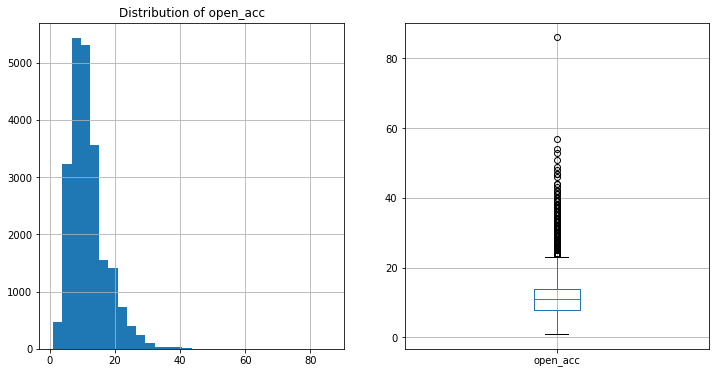

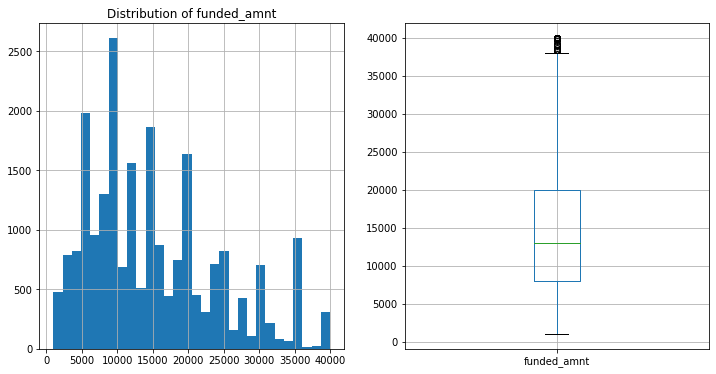

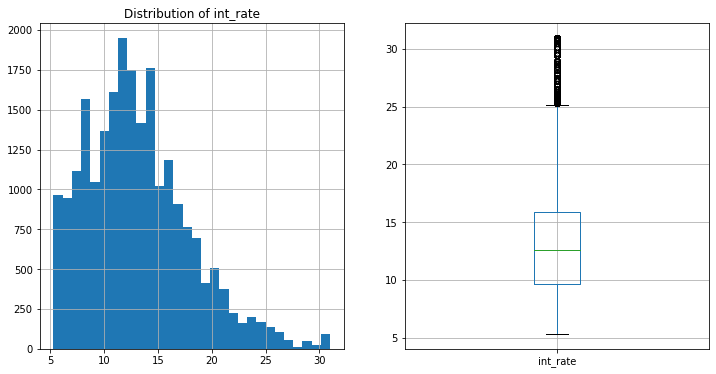

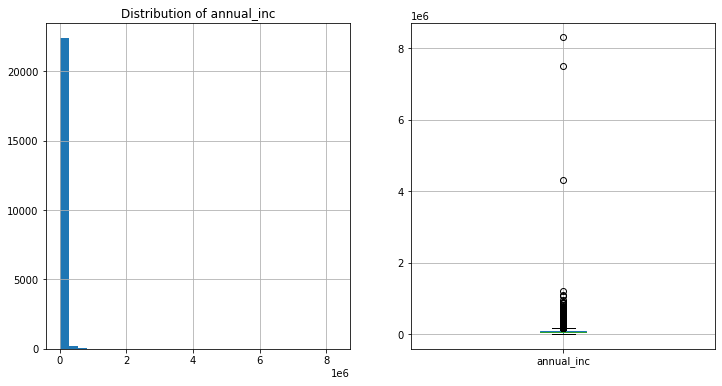

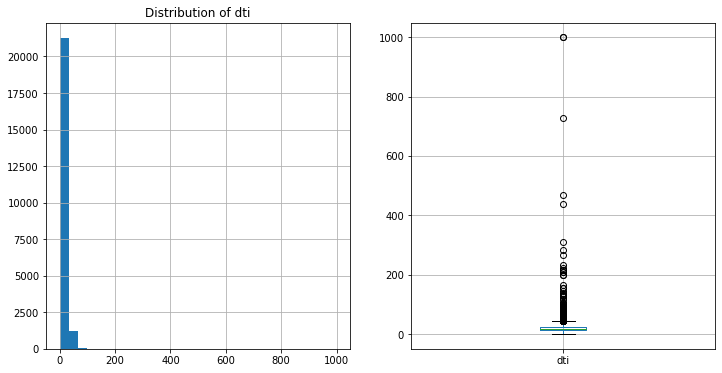

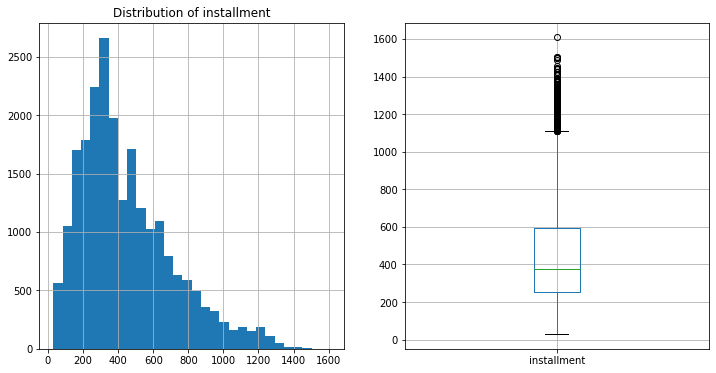

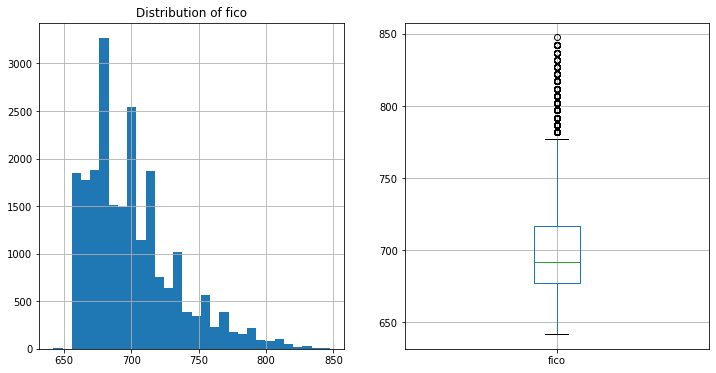

In [ ]:
#Code borrowed from class notebook. 
#We are using histograms and box-plots to check for outliers
#Creating a for loop running through float types
for col in data[float_types]:
    #For each column we create space for one row with 2 charts 
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    #The first chart is a histogram 
    data[float_types][col].hist(bins = 30, ax = axes[0])
    #The title for the chart is created here 
    axes[0].set_title('Distribution of '+ col)
    #The boxplot is created for the column
    data[float_types].boxplot(column = col, ax = axes[1])
    #This command displays the charts
    plt.show()

# Define a function that identifies outlier cases

In [ ]:
#Code borrowed from class notebook.
#We are defining a function that can be used on any dataset to return a list of index values for the outliers 
def get_outliers(data, columns):
    #We create an empty list
    outlier_idxs = []
     #The standard deviations needed
    nsd = 3 
    #We loop over all columns passed into the function
    for col in columns:
        elements = data[col]
        #We get the mean value for each column
        mean = elements.mean()
        #We get the standard deviation of the column
        sd = elements.std()
        #We get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        #We add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
        #We return a list of the outliers index
    return list(set(outlier_idxs))

# Call the function that identifies outliers. 
- drop the idenitied outliers from out data
### Caution: Running this function call multiple times will continue to decrease the size of your data


In [ ]:
#Code borrowed from class notebook.
#We check how many observations we have and print the results
print (f"Number of Observations and Features before Cleaning: {data[float_types].shape}")
#We call the function we just created on the boston dataset
outliers = get_outliers(data[float_types], float_types)
#We drop those records from our feature and response data
data = data.drop(outliers, axis = 0)
#We check that this code has worked by looking at the shape of our data 
print (f"Number of Observations and Features after Cleaning: {data[float_types].shape}")
#Careful when running cell as more data will be removed

Number of Observations and Features before Cleaning: (22586, 7)
Number of Observations and Features after Cleaning: (21502, 7)


# Re-examine the distirbution for each features, now that we have dropped outlier cases

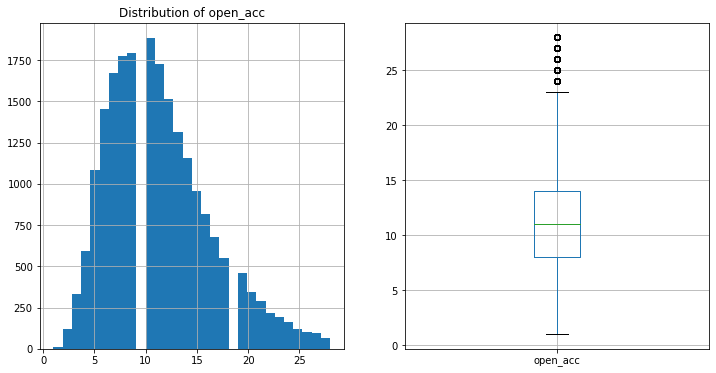

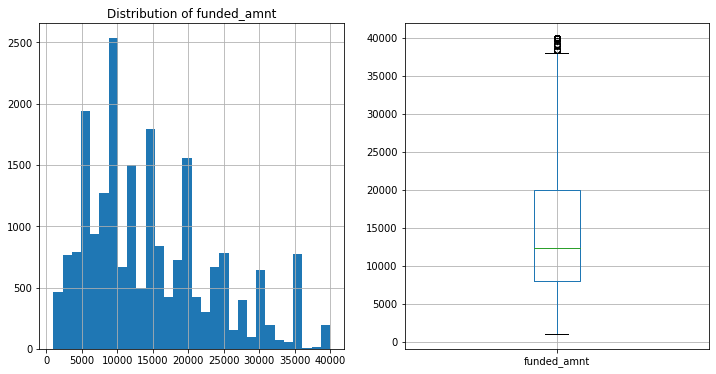

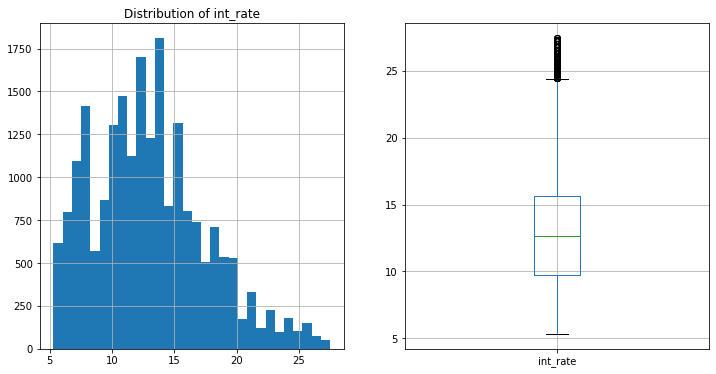

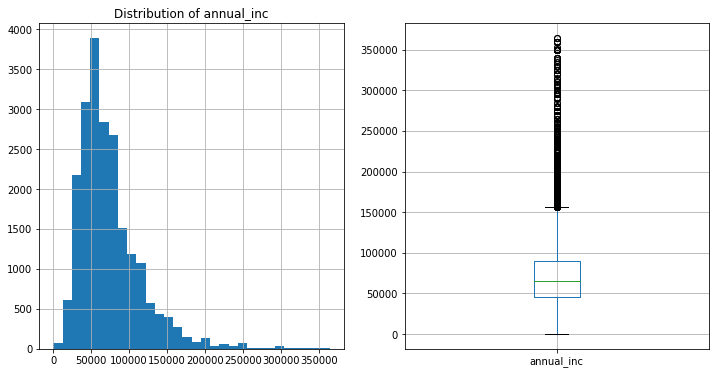

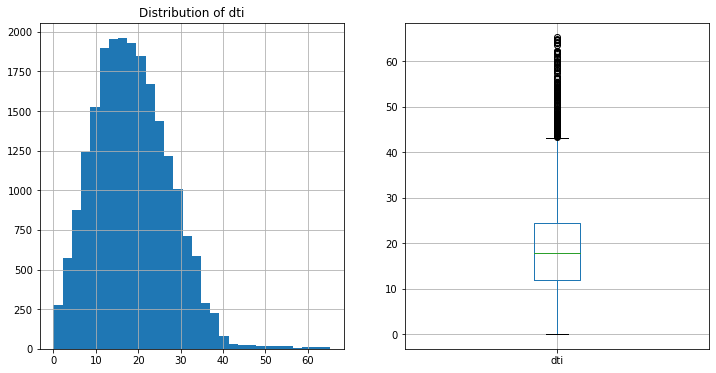

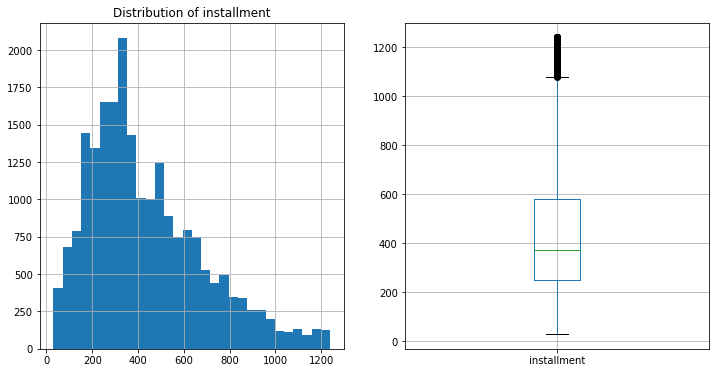

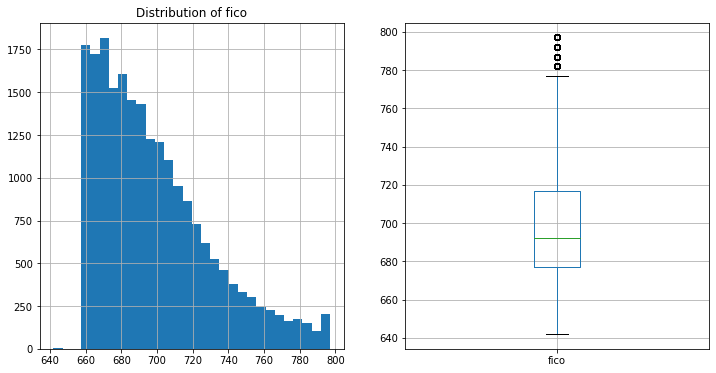

In [ ]:
#Code borrowed from class notebook.
#Checking histogram and box plots after removing outliers in for loop
for col in data[float_types]:
    #For each column we create space for one row with 2 charts  
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    #Our first chart is a histogram and we set the title 
    data[float_types][col].hist(bins = 30, ax = axes[0])
    #We set the title of our histogram
    axes[0].set_title('Distribution of '+ col)
    #We created a boxplot of the column
    data[float_types].boxplot(column = col, ax = axes[1])
    #We use this to command to display the charts
    plt.show()

# Feature Engineering: 

## The next portion of this notebook focuses on preparing key features for out model. 

### 'expected_total_payment': This feature is created by multiplying the term length (36 or 60) by the 'installment'
   - Add this engineered feature to your data set
   - This data is how much money you can expect from a loan, provided they make all the borrower makes all their payments. 

### Loan Status 
   - There are multiple levels to the loan status: Fully Paid, Current, Charged Off, Late (31-120 days), In Grace Period, Late (16-30 days), Does not meet the credit policy. Status: Fully Paid,  Does not meet the credit policy. Staus: Charged Off, and Default. 
   - We narrow our focus to just include the Charged Off and Fully Paid Loans because these are the only loans for which we know their ending status. 

In [ ]:
#Created a variable expected_total_paymenet which is calculated by multiplying term and installment 
data['expected_total_payment'] = data['term'].astype(int) * data['installment']
#Show the column of expected total payment
data['expected_total_payment']

0        38023.80
2        10431.36
3        36639.60
4        12853.80
5        22399.20
           ...   
22581    16398.00
22582    46416.60
22583     9741.60
22584    53314.80
22585    46953.00
Name: expected_total_payment, Length: 21502, dtype: float64

# Loan Status
- Look at the contents of the feature using value_counts
- drop the loans that are not in a definite ending status. 

In [ ]:
#Make sure expected total payment was added as a column
data.columns
#Count unique values in loan status
data['loan_status'].value_counts()

Fully Paid                                             10340
Current                                                 8256
Charged Off                                             2552
Late (31-120 days)                                       191
In Grace Period                                           86
Late (16-30 days)                                         48
Does not meet the credit policy. Status:Fully Paid        24
Does not meet the credit policy. Status:Charged Off        5
Name: loan_status, dtype: int64

In [ ]:
# dropping loans that are not of Full Paid Off or Charged Off status 
s_drop = ['Current', 'Does not meet the credit policy. Status:Charged Off', 'Does not meet the credit policy. Status:Fully Paid', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']
#Retrives the data of loan status that are fully paid or charged off
data_c = data.loc[(data['loan_status'] == "Fully Paid") | (data['loan_status'] == "Charged Off")].copy()
#Remove the unused categories in loan status
data_c['loan_status'] = data_c['loan_status'].cat.remove_unused_categories()
#Determine the counts on loan status for fully paid and charged off
data_c['loan_status'].value_counts()

Fully Paid     10340
Charged Off     2552
Name: loan_status, dtype: int64

# An exploratory look at how the two loan status levels relate to the loan sub-grade. 

In [ ]:
#Group based on sub grade and loan status with respective sums of other variables in following columns
data_c.groupby((["sub_grade","loan_status"])).sum()
tab = pd.crosstab(index = data_c['sub_grade'], columns = data_c['loan_status'])
#Print the tab object
print(tab)

loan_status  Charged Off  Fully Paid
sub_grade                           
A1                    10         360
A2                    19         343
A3                    19         321
A4                    30         416
A5                    62         577
B1                    68         617
B2                    79         634
B3                    89         692
B4                   128         729
B5                   126         668
C1                   150         678
C2                   146         680
C3                   185         532
C4                   192         563
C5                   182         468
D1                   134         347
D2                   126         316
D3                   112         276
D4                   103         229
D5                    88         205
E1                    93         137
E2                    90         121
E3                    58          92
E4                    74          96
E5                    57          71
F

In [ ]:
#Created default_risk column which is calculated by dividing charged off by the total of charged off and fully paid
tab['default_risk'] = tab['Charged Off']/(tab['Charged Off'] + tab['Fully Paid'])
#Make a copy of default risk and store it in a new object
tab_lookup = tab['default_risk'].copy()
#Print tab lookup
tab_lookup

sub_grade
A1    0.027027
A2    0.052486
A3    0.055882
A4    0.067265
A5    0.097027
B1    0.099270
B2    0.110799
B3    0.113956
B4    0.149358
B5    0.158690
C1    0.181159
C2    0.176755
C3    0.258020
C4    0.254305
C5    0.280000
D1    0.278586
D2    0.285068
D3    0.288660
D4    0.310241
D5    0.300341
E1    0.404348
E2    0.426540
E3    0.386667
E4    0.435294
E5    0.445312
F1    0.473684
F2    0.428571
F3    0.440000
F4    0.363636
F5    0.437500
G1    0.529412
G2    0.428571
G3    0.416667
G4    0.000000
G5    0.500000
Name: default_risk, dtype: float64

# Random Forest: 
- We begin our analysis with a baseline Random Forest Model 
    - The first few cells focus on ensuring the data is correctly type casted and gaining an overview of our data. 

In [ ]:
#Print head of cleaned data
data_c.head()

,open_acc,funded_amnt,int_rate,term,verification_status,annual_inc,dti,installment,application_type,emp_length,grade,sub_grade,home_ownership,loan_status,issue_d,fico,issue_yr,expected_total_payment
0,10.0,23975.0,19.89,60,Not Verified,70000.0,33.20,633.73,Individual,10+ years,E,E3,RENT,Charged Off,Dec-2015,687.0,2015,38023.80
3,11.0,26250.0,13.99,60,Verified,65000.0,26.90,610.66,Individual,10+ years,C,C4,MORTGAGE,Fully Paid,Dec-2015,702.0,2015,36639.60
4,15.0,11200.0,9.17,36,Not Verified,53000.0,11.96,357.05,Individual,10+ years,B,B2,MORTGAGE,Fully Paid,Dec-2015,722.0,2015,12853.80
6,20.0,6000.0,5.32,36,Not Verified,80000.0,13.50,180.69,Individual,10+ years,A,A1,MORTGAGE,Fully Paid,Dec-2015,747.0,2015,6504.84
7,9.0,30000.0,19.48,60,Source Verified,88000.0,18.47,786.17,Individual,10+ years,E,E2,MORTGAGE,Fully Paid,Dec-2015,667.0,2015,47170.20


In [ ]:
#Print head of cleaned data
data_c['term'] = data_c['term'].astype(int)
#Converting issue year to a data type of integer
data_c['issue_yr'] = data_c['issue_yr'].astype(int)
#Dropping issue date column
data_c = data_c.drop(['issue_d'], axis = 1)

In [ ]:
#Checking what is in cleaned data now after type casting and dropping variables
data_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12892 entries, 0 to 22583
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   open_acc                12892 non-null  float64 
 1   funded_amnt             12892 non-null  float64 
 2   int_rate                12892 non-null  float64 
 3   term                    12892 non-null  int64   
 4   verification_status     12892 non-null  category
 5   annual_inc              12892 non-null  float64 
 6   dti                     12891 non-null  float64 
 7   installment             12892 non-null  float64 
 8   application_type        12892 non-null  category
 9   emp_length              12154 non-null  category
 10  grade                   12892 non-null  category
 11  sub_grade               12892 non-null  category
 12  home_ownership          12892 non-null  category
 13  loan_status             12892 non-null  category
 14  fico                  

In [ ]:
#Finding the sum of the missing values in the cleaned data
data_c.isna().sum()
#Drop the cases of missing values
data_c = data_c.dropna(axis = 1)
#Confirm the missing value some is now 0 after dropping from before
data_c.isnull().sum()

open_acc                  0
funded_amnt               0
int_rate                  0
term                      0
verification_status       0
annual_inc                0
installment               0
application_type          0
grade                     0
sub_grade                 0
home_ownership            0
loan_status               0
fico                      0
issue_yr                  0
expected_total_payment    0
dtype: int64

In [ ]:
#Make a copy of the grade column
grade = data_c['grade'].copy()
#Make a copy of the sub grade column
sub_grade = data_c['sub_grade'].copy()
#Keep the data with issue years greater than 2012
mod_dt = data_c[(data_c["issue_yr"] >= 2012)]
#Checking all possible issue years that are there now
mod_dt['issue_yr'].unique()

array([2015, 2018, 2017, 2016, 2014, 2013, 2012])

# Split the data into Testing and Training data sets 
- Our training data includes observations where a loan was issued from 2012 -2016
-Our testing data includes observations where a loan was issued from 2017-2018

### In order to check that the split occured as expected, we count the number of unique values in the 'issue_yr' feature for our training and testing data. 

In [ ]:
#Assigning test data to be all data with an issue year greater than or equal to 2017
test_data = mod_dt[mod_dt['issue_yr'] >= 2017]
#Assigning training data to be all data with an issue year less than 2017
train_data = mod_dt[mod_dt['issue_yr'] < 2017]
#Printing the number of unique values in the testing data's issue year column. We expect two
print(test_data['issue_yr'].nunique())
#Printing the number of unique values in the training data's issue year column. We expect five
print(train_data['issue_yr'].nunique())

2
5


In [ ]:
#Current columns in training data
train_data.columns

#Borrowed from class notes
#Create a new dataframe X that includes only our feature variables
X_train = train_data.loc[:,data_c.columns != 'loan_status'].copy()
#Create a new dataframe y that includes only our feature variables
y_train = train_data['loan_status'].copy()
#Retrieve everything but the loan status column from X test data
X_test = test_data.loc[:,data_c.columns != 'loan_status'].copy()
#Retrieve the loan status column from y test data
y_test = test_data['loan_status'].copy()
#One hot encode the categorical features to make them machine readable for X_test 
X_test = pd.get_dummies(X_test, drop_first=False).copy()
#One hot encode the categorical features to make them machine readable for X_train 
X_train= pd.get_dummies(X_train, drop_first=False).copy()
#Show the first five rows of X_train
display(X_train.head())
#Calculate the sum of the missing values from the X training data
X_train.isna().sum()
#Calculate the sum of the missing values from the y training data
y_train.isnull().sum()
#Shows us the number of rows and columns in y_train
y_train.shape

,open_acc,funded_amnt,int_rate,term,annual_inc,installment,fico,issue_yr,expected_total_payment,verification_status_Not Verified,...,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,10.0,23975.0,19.89,60,70000.0,633.73,687.0,2015,38023.80,1,...,0,0,0,0,0,0,0,0,0,1
3,11.0,26250.0,13.99,60,65000.0,610.66,702.0,2015,36639.60,0,...,0,0,0,0,0,0,1,0,0,0
4,15.0,11200.0,9.17,36,53000.0,357.05,722.0,2015,12853.80,1,...,0,0,0,0,0,0,1,0,0,0
6,20.0,6000.0,5.32,36,80000.0,180.69,747.0,2015,6504.84,1,...,0,0,0,0,0,0,1,0,0,0
7,9.0,30000.0,19.48,60,88000.0,786.17,667.0,2015,47170.20,0,...,0,0,0,0,0,0,1,0,0,0


(10351,)

In [ ]:
#Store X_test expected_total_payment in new object called total_payment_unscaled_test
total_payment_unscaled_test = X_test['expected_total_payment'].copy()
#Store X_train expected_total_payment in new object called total_payment_unscaled
total_payment_unscaled = X_train['expected_total_payment'].copy()
#Store X-train funded_amnt in new object called funded_amnt_unscaled
funded_amnt_unscaled= X_train['funded_amnt'].copy()
#Store X-test funded_amnt in new object called funded_amnt_unscaled_test
funded_amnt_unscaled_test= X_test['funded_amnt'].copy()
#Show what object total_payment_unscaled looks like
total_payment_unscaled

0        38023.80
3        36639.60
4        12853.80
6         6504.84
7        47170.20
           ...   
22578     3075.84
22579    13013.28
22580     4286.52
22582    46416.60
22583     9741.60
Name: expected_total_payment, Length: 10351, dtype: float64

# Define a function that will scale features. 
- Since Random Forest relies on Eucladian distrance, feature scaling is a critical step
- This action maintains each feature's disbtribution while removing the effects of different scales on our model

In [ ]:
#Borrowed from class notes
#This function loops through columns in a feature set and defines a predefined scaler for each
def scale_numeric(features, numeric_features, scaler):
    #For loop through each numeric column
    for col in numeric_features:
       #Reshaping the columns
        features[col] = scaler.fit_transform(features[col].values.reshape(-1, 1))
     #Return the columnn
    return features

#We now define the scaler we want to use and apply it to our features 
#Initialize the list of numeric_features
numeric_features = ['open_acc', 'funded_amnt', 'int_rate', 'term', 'annual_inc',
       'installment', 'fico', 'expected_total_payment']
       #Store MinMaxScaler function in scaler object
scaler = MinMaxScaler()
#Call scale_numeric function in X_train
X_train_scaled = scale_numeric(X_train, numeric_features, scaler)
#Call scale_numeric function in X_test
X_test_scaled = scale_numeric(X_test, numeric_features, scaler)
#Check to see if it worked
X_train_scaled.describe()

,open_acc,funded_amnt,int_rate,term,annual_inc,installment,fico,issue_yr,expected_total_payment,verification_status_Not Verified,...,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
count,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,...,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.000000,10351.0,10351.000000,10351.000000
mean,0.385688,0.341724,0.353143,0.244228,0.189774,0.333298,0.249530,2014.627959,0.285100,0.289344,...,0.001642,0.000676,0.001159,0.000483,0.000193,0.000097,0.505845,0.0,0.102792,0.391267
std,0.184166,0.212267,0.200051,0.429649,0.113415,0.200917,0.212640,1.154210,0.192100,0.453480,...,0.040495,0.025998,0.034031,0.021974,0.013900,0.009829,0.499990,0.0,0.303702,0.488057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.259259,0.179487,0.199820,0.000000,0.113764,0.186116,0.074074,2014.000000,0.138290,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.370370,0.282051,0.339648,0.000000,0.166667,0.285733,0.185185,2015.000000,0.245645,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
75%,0.481481,0.487179,0.464141,0.000000,0.236111,0.452542,0.370370,2016.000000,0.387806,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2016.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [ ]:
#Check to see the missing values in X_train_scaled
X_train_scaled.isna().sum()

open_acc                   0
funded_amnt                0
int_rate                   0
term                       0
annual_inc                 0
                          ..
home_ownership_ANY         0
home_ownership_MORTGAGE    0
home_ownership_OTHER       0
home_ownership_OWN         0
home_ownership_RENT        0
Length: 61, dtype: int64

# This is assurance that our testing and training data have symmetrical shapes. 

In [ ]:

#Check if data have right shape
#Print the train response variable shape
print("Train: Response Variable: ",y_train.shape)
#Print the train feature variables shape
print("Train: Feature Variables: ",X_train_scaled.shape)
#Print the test response variable shape
print("Test: Response Variable: ",y_test.shape)
#Print the test feature variables shape
print("Test: Feature Variables: ",X_test_scaled.shape)

Train: Response Variable:  (10351,)
Train: Feature Variables:  (10351, 61)
Test: Response Variable:  (2140,)
Test: Feature Variables:  (2140, 61)


In [ ]:
#Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, criterion='gini')
#Fit'rf' to the training set
rf.fit(X_train_scaled, y_train)
#Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test_scaled)
#Print model accuracy
print(f'Model Accuracy is {accuracy_score(y_test, y_pred)}\n')

Model Accuracy is 0.7616822429906542



# Model Performance
- we look at a confusion matrix to evaluate the performance of our model. 
- this will give us a better understanding than simly looking at the accuracy score reported above

              precision    recall  f1-score   support

 Charged Off       0.31      0.07      0.12       468
  Fully Paid       0.79      0.95      0.86      1672

    accuracy                           0.76      2140
   macro avg       0.55      0.51      0.49      2140
weighted avg       0.68      0.76      0.70      2140



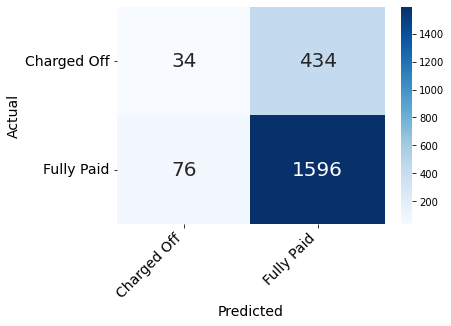

In [ ]:
#Borrowed from class notes
#Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
#Create data frame with confusion matrix labels of charged off and fully paid
confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Fully Paid'), ('Charged Off', 'Fully Paid'))
#Initialize the heatmap confusion matrix
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
#Edit the y axis labels on the heatmap confusion matrix
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
#Edit the x axis labels on the heatmap confusion matrix
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
#Plot the y label actual on the matrix
plt.ylabel('Actual', fontsize = 14)
#Plot the x label predicted on the matrix
plt.xlabel('Predicted', fontsize = 14)
# Print the classification report
print(classification_report(y_test, y_pred))


# Improved Random Forest Model (Model 2)

## Upsampling

- We realized that one major issue with our baseline random forest model is the asymmetry in our training data along our y variable. 
   - Our model is predicitng loan status
   -However, our data has many more 'Fully Paid' loans when compared to 'Charged Off' loans.
- We will upsample the number of 'Charged Off' loans in our training data, so that our model will be able to perform better on our testing data. 

In [ ]:
#Create object minority that contains a loan status of charged off
minority = train_data[train_data['loan_status'] == 'Charged Off']
#Create object majority that contains a loan status of fully paid
majority = train_data[train_data['loan_status'] == 'Fully Paid']

In [ ]:
#Creating half the data by resampling on the size of the majority sample
minority_upsampled = resample(minority, replace = True, n_samples = len(majority.index))
#Join the majority sample and upsampled minority in one object
upsampled_data = majority.append(minority_upsampled)

In [ ]:
#Find the number of charged off and fully paid loans in the unsampled_data
upsampled_data.groupby(['loan_status']).count()

,open_acc,funded_amnt,int_rate,term,verification_status,annual_inc,installment,application_type,grade,sub_grade,home_ownership,fico,issue_yr,expected_total_payment
loan_status,,,,,,,,,,,,,,
Charged Off,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320
Fully Paid,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320,8320


# Split our upsampled data into a training and testing set
- the training data contains cases from years 2012 -2016
- the testing data contains csaes from years 2017-2018

In [ ]:
#Keep the data with issue years greater than 2012
mod_dt = upsampled_data[(upsampled_data["issue_yr"] >= 2012)]
#Assigning test data to be all data with an issue year greater than or equal to 2017
upsampled_test_data = mod_dt[mod_dt['issue_yr'] >= 2017]
#Assigning training data to be all data with an issue year less than 2017
upsampled_train_data = mod_dt[mod_dt['issue_yr'] < 2017]

In [ ]:
# 1 Create a new dataframe X that includes only our feature variables
X_upsampled_train = upsampled_train_data.loc[:,upsampled_data.columns != 'loan_status'].copy()
#Create a new dataframe y that includes loan status
y_upsampled_train = upsampled_train_data['loan_status'].copy()
#Now you need to one hot encode the categorical features to make them machine readable. 
X_upsampled_train = pd.get_dummies(X_upsampled_train, drop_first=False).copy()
#Show the first five rows of X_upsampled_train
display(X_upsampled_train.head())



,open_acc,funded_amnt,int_rate,term,annual_inc,installment,fico,issue_yr,expected_total_payment,verification_status_Not Verified,...,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
3,11.0,26250.0,13.99,60,65000.0,610.66,702.0,2015,36639.60,0,...,0,0,0,0,0,0,1,0,0,0
4,15.0,11200.0,9.17,36,53000.0,357.05,722.0,2015,12853.80,1,...,0,0,0,0,0,0,1,0,0,0
6,20.0,6000.0,5.32,36,80000.0,180.69,747.0,2015,6504.84,1,...,0,0,0,0,0,0,1,0,0,0
7,9.0,30000.0,19.48,60,88000.0,786.17,667.0,2015,47170.20,0,...,0,0,0,0,0,0,1,0,0,0
8,28.0,35000.0,13.44,36,86000.0,1186.72,672.0,2015,42721.92,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Borrowed from class notess
#This function loops through columns in a feature set and defines a predefined scaler to each
def scale_numeric(features, numeric_features, scaler):
  #For loop through the numeric features
    for col in numeric_features:
      #Reshaping the column
        features[col] = scaler.fit_transform(features[col].values.reshape(-1, 1))
    #Return the column
    return features

#We can now define the scaler we want to use and apply it to our features 
#Create an array called numeric_features with numeric variables
numeric_features = ['open_acc', 'funded_amnt', 'int_rate', 'term', 'annual_inc',
       'installment', 'fico', 'expected_total_payment']
       #Store the minmax scaler in scaler
scaler = MinMaxScaler()
#Call scale_numeric function in X_upsampled_train
X_upsampled_train = scale_numeric(X_upsampled_train, numeric_features, scaler)
#Check to see if it worked
X_upsampled_train.describe()

,open_acc,funded_amnt,int_rate,term,annual_inc,installment,fico,issue_yr,expected_total_payment,verification_status_Not Verified,...,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
count,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,...,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.0,16640.000000,16640.000000
mean,0.388626,0.350629,0.393946,0.303125,0.185033,0.338495,0.229073,2014.678786,0.301009,0.269892,...,0.002825,0.001262,0.001863,0.000300,0.000421,0.000060,0.481971,0.0,0.104567,0.413401
std,0.185093,0.213457,0.208134,0.459623,0.111955,0.199274,0.201653,1.143423,0.199912,0.443917,...,0.053073,0.035504,0.043123,0.017332,0.020507,0.007752,0.499690,0.0,0.306004,0.492458
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.259259,0.179487,0.255751,0.000000,0.111111,0.195270,0.074074,2014.000000,0.145618,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.370370,0.307692,0.376635,0.000000,0.158333,0.293537,0.185185,2015.000000,0.262377,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.481481,0.487179,0.526387,1.000000,0.227778,0.455062,0.333333,2016.000000,0.421437,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2016.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [ ]:
#Check if data have right shape
#Print the Train: Response Variable shape
print("Train: Response Variable: ",y_upsampled_train.shape)
#Print the Train: Feature Variable shape
print("Train: Feature Variables: ",X_upsampled_train.shape)
#Print the Test: Response Variable shape
print("Test: Response Variable: ",y_test.shape)
#Print the Test: Feature Variable shape
print("Test: Feature Variables: ",X_test.shape)

Train: Response Variable:  (16640,)
Train: Feature Variables:  (16640, 61)
Test: Response Variable:  (2140,)
Test: Feature Variables:  (2140, 61)


In [ ]:
#Fit 'rf' to the rf_upsampled set
rf_upsampled = RandomForestClassifier(n_estimators=25, criterion='gini')
#Fit 'rf' to the rf_upsampled.fit training set
rf_upsampled.fit(X_upsampled_train, y_upsampled_train)
#Predict the test set labels 'y_pred'
y_upsampled_pred = rf_upsampled.predict(X_test)
#Print the model accuracy
print(f'Model Accuracy is {accuracy_score(y_test, y_upsampled_pred)}\n')

Model Accuracy is 0.7593457943925234



# Evaluating Model Performance
- we will be using a confusion matrix t evaluate the performance of our model.

              precision    recall  f1-score   support

 Charged Off       0.39      0.19      0.25       468
  Fully Paid       0.80      0.92      0.86      1672

    accuracy                           0.76      2140
   macro avg       0.60      0.55      0.55      2140
weighted avg       0.71      0.76      0.72      2140



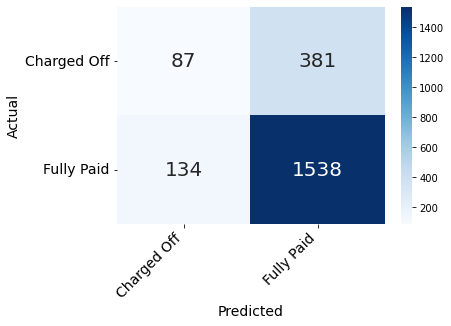

In [ ]:
#Borrowed from class notes
#Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_upsampled_pred)
#Create data frame with confusion matrix labels of charged off and fully paid
confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Fully Paid'), ('Charged Off', 'Fully Paid'))
#Initialize the heatmap confusion matrix
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
#Edit the y axis labels on the heatmap confusion matrix
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
#Edit the x axis labels on the heatmap confusion matrix
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
#Plot the y label actual on the matrix
plt.ylabel('Actual', fontsize = 14)
#Plot the x label predicted on the matrix
plt.xlabel('Predicted', fontsize = 14)
# Print the classification report
print(classification_report(y_test, y_upsampled_pred))
